## Import modules

!pip install numpy pandas matplotlib seaborn scikit-learn scipy pywavelets \
    torch torchvision torchaudio \
    shap imbalanced-learn xgboost catboost interpret

In [33]:
import os
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from torch.utils.data import Dataset

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Dataset, Subset, random_split
from torch.utils.data import ConcatDataset

import pywt
from scipy.signal import welch
from scipy.stats import chi2_contingency, ttest_ind

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, AgglomerativeClustering, SpectralClustering, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import (
    r2_score,
    accuracy_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
    silhouette_score,
)

from sklearn.svm import SVC
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

import shap
from imblearn.over_sampling import SMOTE
from interpret.glassbox import ExplainableBoostingClassifier
from interpret import show

from matplotlib.lines import Line2D
from matplotlib.gridspec import GridSpec
from mpl_toolkits.mplot3d import Axes3D

## Dataset Definition

This script orchestrates the end-to-end process of loading, preprocessing, augmenting, and
splitting multi‐channel EEG data for training a Variational Autoencoder (VAE) (or similar
neural network) on a 16h–68h observation window. It also builds PyTorch DataLoaders
for training and testing, with optional label‐driven augmentation.

Usage:
    1. Adjust hyperparameters and paths in the “Hyperparameter settings” section:
       - latent_dim:       dimensionality of the VAE’s latent space.
       - initial_channels: number of initial convolutional channels (for CNN-based encoder/decoder).
       - start_time:       starting hour (16) to define the 16h–68h window.
       - seq_length:       automatically computed as (68 − start_time) × 12
                           (= number of 5-minute windows for a 52h span).
       - batch_size, epochs, alpha, patience: standard training parameters.
       - padding_method:   padding strategy for signals (e.g., 'constant', 'reflect', etc.).
       - is_augment:       whether to perform label‐based augmentation.
       - num_good_*/num_bad_*: repetition multipliers for “good outcome” vs. “bad outcome” samples.
       - column_names:     list of EEG feature columns to load from each CSV.

    2. Point to your data directories:
       - data_folder:         directory containing per‐patient CSV files of smoothed 5-minute EEG.
       - valid_outcome_data:  CSV that maps patient IDs to “Good Outcome” / “Bad Outcome”.
       - ssd_file:            CSV that contains each patient’s “rosc_sec” timestamp.

    3. Instantiate EEGDataset:
       - The dataset loader automatically:
         • Reads every CSV in data_folder.
         • Extracts only the columns specified in `column_names`.
         • Looks up the patient’s `rosc_sec` from ssd_file and aligns the raw signal to 
           the 16h–68h window (truncating or padding as needed).
         • If use_labels=True, filters out any files not listed in valid_outcome_data.
         • Records how many “Good Outcome” vs. “Bad Outcome” samples remain after filtering.

    4. Filter out samples with NaN values:
       - `filter_nan_data` scans through the dataset and returns two index lists:
         • clean_indices: no NaN present in any channel/timepoint.
         • nan_indices: at least one NaN in the aligned signal.
       - One random “clean” sample is removed from the main dataset and stored separately in 
         `clean_dataset` (for later inspection, visualization, or debugging).
       - The remaining indices (both clean and NaN) form `eeg_dataset_1`, from which we split 
         train/test sets. This step helps ensure that your training loop never sees NaNs.

    5. Split into train/test:
       - `train_size = int(0.8 * len(eeg_dataset_1))`
       - `test_size = len(eeg_dataset_1) − train_size`
       - Uses `torch.utils.data.random_split` to create `train_dataset` and `test_dataset`.

    6. (Optional) Label‐based data augmentation:
       - Wrap `train_dataset` and `test_dataset` with `AugmentedEEGDataset(...)`.
       - If is_augment=True, it repeats “Good Outcome” samples `num_good_*` times and 
         “Bad Outcome” samples `num_bad_*` times. Otherwise, each sample is used once.

    7. Construct DataLoaders:
       - If `is_VAEtrain_aug` is True, the DataLoaders use augmented datasets; otherwise, 
         they use the unaugmented subsets.
       - `train_loader = DataLoader(..., shuffle=True)`
       - `test_loader  = DataLoader(..., shuffle=False)`

    8. Downstream model training (outside this script):
       - Move each batch to `device` (GPU if available).
       - Define your VAE or CNN‐based encoder/decoder using `latent_dim` and `initial_channels`.
       - Use the DataLoaders to feed mini‐batches into your training loop, computing losses
         (e.g., reconstruction + KL divergence weighted by `alpha`), and implement early stopping
         based on `patience`.

Redundancy & Extension Notes:
    - Several blocks (e.g., padding options, augmentation multipliers, column_names lists)
      appear redundant but are included to cover multiple experimentation scenarios. Although
      not strictly necessary to modify every option, they complement each other when you
      want to compare:
        • Different padding strategies (‘constant’, ‘reflect’, ‘cyclic’, etc.).
        • Various feature subsets in `column_names`.
        • Label‐driven augmentation ratios (1:1, 10:1, etc.).
      We recommend leaving these extensions intact unless you have a clear reason to remove
      them for simplicity. They enable quick ablation studies on preprocessing and augmentation.

In [34]:
class EEGUtil:
    @staticmethod
    def load_data(file_path, column_names=['spike hz']):
        """Load multi-channel EEG data from a CSV file and normalize it.

        Parameters:
        - file_path: Path to the CSV file.
        - column_names: List of EEG signal column names to load.

        Returns:
        - signal: 2D numpy array (channels × time), normalized.
        """
        data = pd.read_csv(file_path)

        available_columns = [col for col in column_names if col in data.columns]
        if not available_columns:
            raise ValueError(f"None of the specified columns {column_names} exist in {file_path}")

        signal = data[available_columns].values.T  # (channels, time)

        mean = np.mean(signal, axis=1, keepdims=True)
        std = np.std(signal, axis=1, keepdims=True) 
        std[std == 0] = 1e-8  
        
        return signal

    @staticmethod
    def padding(signal, target_length, mode="constant", constant_value=0):
        """Pad or truncate multi-channel signal to the target length."""
        signal = np.array(signal)  # Ensure it's a NumPy array
        channels, current_length = signal.shape
        
        if current_length >= target_length:
            return signal[:, :target_length]  # Truncate

        padding_size = target_length - current_length
        if mode == "constant":
            pad_values = np.full((channels, padding_size), constant_value)
        elif mode == "reflect":
            pad_values = np.pad(signal, ((0, 0), (0, padding_size)), mode='reflect')[:, -padding_size:]
        elif mode == "cyclic":
            pad_values = np.pad(signal, ((0, 0), (0, padding_size)), mode='wrap')[:, -padding_size:]
        elif mode == "edge":
            pad_values = np.pad(signal, ((0, 0), (0, padding_size)), mode='edge')[:, -padding_size:]
        elif mode == "random":
            pad_values = np.random.uniform(low=np.min(signal), high=np.max(signal), size=(channels, padding_size))
        else:
            raise ValueError(f"Unsupported padding mode: {mode}")

        return np.hstack((signal, pad_values))  # Concatenate along time axis
    

class EEGDataset(Dataset):
    def __init__(self, data_folder, outcome_file=None, ssd_file=None,start_time=16,target_length=600, strategy='padding', 
                 padding_mode="constant", use_labels=False, augment=False,num_good=1,num_bad=1,column_names=['spike hz']):
        
        """
        EEG signal datasets with support for data enhancement (random fill). 

        Parameters: 
        - data_folder: path of the EEG data folder 
        - outcome_file: CSV file with patient ID and outcome (optional) 
        - target_length: indicates the padding length of the target 
        - strategy: wavelet ('padding', 'wavelet', 'psd') 
        - padding_mode: indicates the fill mode ('constant', 'reflect',...). 
        - use_labels: indicates whether to use labels 
        - augment: Whether data enhancement is enabled (randomly fill different lengths) 
        """

        self.use_labels = use_labels
        self.data_folder = data_folder
        self.target_length = target_length
        self.strategy = strategy
        self.padding_mode = padding_mode
        self.augment = augment 
        self.column_names = column_names #Feature Chosen
        
        self.num_good = num_good
        self.num_bad = num_bad
        
        self.start_time=start_time
        self.end_time=int((target_length/12)+self.start_time)

        self.file_list = [f for f in os.listdir(data_folder) if f.endswith('.csv')]
       
        # Read 'rosc sec' start time
        ssd_df = pd.read_csv(ssd_file)
        # Get `pat_ID`
        ssd_df["pat_ID"] = ssd_df["fn"].str.extract(r"(ICARE_\d+)")
        #  Take the smallest 'rosc sec' of each 'pat ID' 
        self.rosc_dict = ssd_df.groupby("pat_ID")["rosc_sec"].min().to_dict()
        
        # LOAD Labels
        self.outcome_dict = {}
        if use_labels and outcome_file:
            self.outcome_data = pd.read_csv(outcome_file)
            self.outcome_dict = self.outcome_data.set_index('pat_ID')['outcome'].to_dict()
            self.file_list = [f for f in self.file_list if f.split('.')[0] in self.outcome_dict]
        
        self.valid_files = []
        # Filter EEG data conforming to 16h-68h rules
        for f in self.file_list:
            pat_id = f.split('.')[0]

            if pat_id in self.rosc_dict:
                file_path = os.path.join(self.data_folder, f)
                signal = EEGUtil.load_data(file_path, column_names=self.column_names)  #Load Multiple Channel
                rosc_sec = float(self.rosc_dict[pat_id])  # Ensure `rosc_sec` is a float

                # **EEG recording time range**
                start_time = rosc_sec
                end_time = start_time + signal.shape[1] * 300  # Each point represents 5 minutes (=300 seconds)
                # **Skip if the data is completely outside the 16h-68h observation window**
                if end_time < self.start_time * 3600 or start_time > self.end_time * 3600:
                    #print(f"❌ Skipping {pat_id}: EEG data is out of 16h-68h range ({start_time/3600:.1f}h - {end_time/3600:.1f}h)")
                    continue  

                # **Align to the 16h-68h window**
                aligned_signal = self.align_signal(signal, rosc_sec)
                self.valid_files.append((f, aligned_signal))

        print(f"✅ Loaded {len(self.valid_files)} valid EEG files (filtered from {len(self.file_list)} total)")

        # **Count Good/Bad Outcome samples**
        self.good_outcome_count = sum(1 for f, _ in self.valid_files if self.get_label(f.split('.')[0]) == 1)
        self.bad_outcome_count = len(self.valid_files) - self.good_outcome_count

        print(f"Good Outcome: {self.good_outcome_count}, Bad Outcome: {self.bad_outcome_count}")

        # **Data Augmentation: Expanding indices**
        self.expanded_indices = []
        for idx, (filename, signal) in enumerate(self.valid_files):
            patient_id = filename.split('.')[0]
            label = self.get_label(patient_id) if self.use_labels else -1

            if self.augment:
                if self.use_labels:
                    # Good Outcome ×10, Bad Outcome ×2
                    if label == 1:
                        repeat_times = self.num_good
                    else:
                        repeat_times = self.num_bad
                else:
                    repeat_times = 1  # Data augmentation for unlabeled data
            else:
                repeat_times = 1  

            for _ in range(repeat_times):
                self.expanded_indices.append((idx, label))  # ✅ Store index & label
    
    def __len__(self):
        # print(f"📏 Dataset __len__: {len(self.expanded_indices)}")  # Ensure `expanded_indices` length is correct
        return len(self.expanded_indices)  # ✅ Must return the number of samples after data augmentation
    
    def __getitem__(self, idx):
        original_idx, label = self.expanded_indices[idx]
        filename, signal = self.valid_files[original_idx]  # Directly retrieve the **aligned** signal
        patient_id = filename.split('.')[0]

        # Get label
        label = -1
        if self.use_labels:
            label = self.get_label(patient_id)

        # Perform data augmentation (varies each time)
        if self.augment:
            augmented_signal = self.augment_signal(signal)  # ✅ Apply augmentation directly to the **aligned signal**
        else:
            augmented_signal = signal  # ✅ Use the aligned signal directly

        return torch.tensor(augmented_signal, dtype=torch.float32), label
    
    def align_signal(self, signal, rosc_sec):
        """ Align EEG data to the 16h-68h observation period """

        target_length = self.target_length  # Number of `5min` windows for 52 hours (624)
        total_signal_length = signal.shape[1]  # Total length of the EEG recording
        
        rosc_sec = float(rosc_sec)  # ✅ Ensure `rosc_sec` is a float
        # print(f"🔍 Processing patient data: rosc_sec={rosc_sec}, total_signal_length={total_signal_length}")

        # **Calculate the starting position of '16h' in the EEG recording**
        start_sec = (self.start_time * 3600) - rosc_sec  
        if start_sec < 0:
            pad_size = abs(start_sec) / 300  # Calculate the number of windows to pad
            start_index = 0  # Start extracting data from the beginning of the EEG recording
        else:
            pad_size = 0  # No padding needed
            start_index = int(start_sec // 300)  # ✅ Convert to integer

        # **Calculate the endpoint index for '68h'**
        end_index = int(min(start_index + target_length, total_signal_length))  # ✅ Convert to integer

        # **Extract EEG data for the 16h-68h observation period**
        aligned_signal = signal[:, start_index:end_index]

        # **Pre-padding (if `rosc_sec > 16h`)**
        if pad_size > 0:
            aligned_signal = EEGDataset.pad_signal(aligned_signal, target_length, self.padding_mode, padding_position="pre")

        # **Post-padding (if data is less than 52 hours)**
        aligned_signal = EEGDataset.pad_signal(aligned_signal, target_length, self.padding_mode, padding_position="post")

        # print(f"✅ Aligned signal length: {len(aligned_signal)}")
        return aligned_signal
    
    def pad_signal(signal, target_length, mode="constant", constant_value=np.nan, padding_position="post"):
        """ Pad EEG signal to ensure it reaches `target_length`.

        Parameters:
        - signal: Original EEG signal (numpy array)
        - target_length: Target length (52h = 624 `5min` windows)
        - mode: Padding mode:
            - `constant`: Fill with a fixed value (`constant_value`)
            - `reflect`: Mirror padding
            - `cyclic`: Cyclic padding
            - `edge`: Edge padding
            - `random`: Fill with random values between [min, max]
        - padding_position: `"pre"` (pad at the beginning) or `"post"` (pad at the end)

        Returns:
        - Padded EEG signal (numpy array)
        """

        channels, current_length = signal.shape
        
        if current_length >= target_length:
            return signal[:, :target_length]  # Truncate if already long enough

        padding_size = target_length - current_length  # Number of elements to pad

        if mode == "constant":
            pad_values = np.full((channels, padding_size), constant_value)  # Make sure padding shape matches
        elif mode == "reflect":
            pad_values = np.pad(signal, ((0, 0), (0, padding_size)), mode='reflect')[:, -padding_size:]
        elif mode == "cyclic":
            pad_values = np.pad(signal, ((0, 0), (0, padding_size)), mode='wrap')[:, -padding_size:]
        elif mode == "edge":
            pad_values = np.pad(signal, ((0, 0), (0, padding_size)), mode='edge')[:, -padding_size:]
        elif mode == "random":
            pad_values = np.random.uniform(low=np.min(signal), high=np.max(signal), size=(channels, padding_size))
        else:
            raise ValueError(f"Unsupported padding mode: {mode}")

        # Ensure proper concatenation along the time axis
        if padding_position == "pre":
            padded_signal = np.hstack((pad_values, signal))  # Pad at the beginning
        else:
            padded_signal = np.hstack((signal, pad_values))  # Pad at the end

        return padded_signal[:, :target_length]  # Ensure exact target length
    
    def augment_signal(self, signal):
        """ Data augmentation: Shift EEG data within the 16h-68h observation period """

        target_length = self.target_length  # Number of `5min` windows for 52 hours (624)
        channels, current_length = signal.shape  # Current EEG recording length

        # **Check if already aligned to 16h-68h before augmentation**
        if current_length != target_length:
            raise ValueError(f"Before augmentation, signal length should be {target_length}, but received {current_length}")

        # **Augmentation Strategy 1: Random time shift within ±60min**
        max_shift = 12  # `5min` windows, 60 minutes = 12 data points
        shift = np.random.randint(-max_shift, max_shift + 1)  # Random shift in [-12, 12]

        # **Compute new starting index and ensure it remains within bounds**
        start_index = max(0, min(current_length - target_length, shift))
        end_index = min(start_index + target_length, current_length)

        # **Extract EEG data after shifting**
        augmented_signal = signal[:, start_index:end_index]

        # **Augmentation Strategy 2: Apply padding based on `shift` direction**
        if augmented_signal.shape[1] < target_length:
            padding_size = target_length - augmented_signal.shape[1]

            if shift > 0:
                pad_values = self.pad_signal(np.zeros((channels, padding_size)), target_length, self.padding_mode)
                augmented_signal = np.hstack((pad_values, augmented_signal))  # **确保形状正确**
            elif shift < 0:
                pad_values = self.pad_signal(np.zeros((channels, padding_size)), target_length, self.padding_mode)
                augmented_signal = np.hstack((augmented_signal, pad_values))
            else:
                augmented_signal = self.pad_signal(augmented_signal, target_length, self.padding_mode)

        return augmented_signal

    def get_label(self, patient_id):
        """ Get sample label (1 = Good Outcome, 0 = Bad Outcome) """
        return 1 if self.outcome_dict.get(patient_id, 'Bad Outcome') == 'Good Outcome' else 0

    def compare_data_augmentation(self):
        """ Compare the number of samples before and after data augmentation. """
        original_count = len(self.valid_files)  # Count only files that meet the 16h condition
        augmented_count = len(self.expanded_indices)  # Count the number of augmented samples

        print(f"Data count before augmentation: {original_count}")
        print(f"Data count after augmentation: {augmented_count}")
        print(f"Augmentation ratio: {augmented_count / original_count:.2f}x")

        if self.use_labels:
            # Count Good Outcome and Bad Outcome samples in original data (filtered_files)
            good_outcome_original = sum(1 for f, _ in self.valid_files if self.get_label(f.split('.')[0]) == 1)
            bad_outcome_original = original_count - good_outcome_original  # Remaining are Bad Outcome samples

            # Count Good Outcome and Bad Outcome samples after augmentation
            good_outcome_augmented = sum(
                1 for (idx, _) in self.expanded_indices  # ✅ Use only idx, ignore label
                if self.get_label(self.valid_files[idx][0].split('.')[0]) == 1
            )
            bad_outcome_augmented = augmented_count - good_outcome_augmented  # Remaining are Bad Outcome samples

            print(f"Good Outcome before augmentation: {good_outcome_original}, after augmentation: {good_outcome_augmented}")
            print(f"Bad Outcome before augmentation: {bad_outcome_original}, after augmentation: {bad_outcome_augmented}")

        return original_count, augmented_count
    
    
# AugmentedEEGDataset 
class AugmentedEEGDataset(torch.utils.data.Dataset):
    def __init__(self, base_dataset, eeg_dataset_instance, augment=True, num_good=10, num_bad=2):
        self.base_dataset = base_dataset
        self.eeg_dataset_instance = eeg_dataset_instance 
        self.augment = augment
        self.num_good = num_good
        self.num_bad = num_bad
        self.expanded_data = []

        for i in range(len(base_dataset)):
            signal, label = base_dataset[i]
            repeat = num_good if label == 1 else num_bad

            for _ in range(repeat):
                signal_np = signal.numpy()
                if signal_np.ndim == 2:
                    augmented_signal = self.eeg_dataset_instance.augment_signal(signal_np)
                else:
                    augmented_signal = self.eeg_dataset_instance.augment_signal(signal_np[np.newaxis, :])  # **单通道兼容**

                self.expanded_data.append((augmented_signal, label))

    def __len__(self):
        return len(self.expanded_data)

    def __getitem__(self, idx):
        signal, label = self.expanded_data[idx]
        return torch.tensor(signal, dtype=torch.float32), label

def count_labels(dataset):
    labels = [dataset[i][1] for i in range(len(dataset))] 
    unique, counts = np.unique(labels, return_counts=True)
    return dict(zip(unique, counts))

In [35]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# Hyperparameter settings
latent_dim = 10  # Dimension of the latent space
initial_channels = 128  # Initial number of channels for CNN
start_time=16 #Set initial hour
seq_length = (68 - start_time) * 12  # Number of `5min` windows for 52 hours (624)
batch_size = 32
epochs = 100
alpha = 1e-12  # Adjust KL divergence weight
patience = 10  # Define the number of epochs without improvement before stopping training
padding_method = 'constant'  # Use constant padding
is_augment = False  # Do not use
is_VAEtrain_aug=False # Do not use
num_good_train=1
num_bad_train=1
num_good_test=1
num_bad_test=1
column_names=['ssd','BCI','avgspectent', 'lv_l5']
num_eeg_channels=len(column_names)

# Define dataset folder paths
data_folder = '5min_smoothed_data/'  # Replace with the actual data folder path
valid_outcome_data = 'valid_patients_outcome.csv'
ssd_file = 'files_art_ssd_fts_predictions.csv'

# Create EEG dataset (labels are not used when training VAE)
eeg_dataset = EEGDataset(
    data_folder='5min_smoothed_data/',
    outcome_file='valid_patients_outcome.csv',
    ssd_file=ssd_file,
    start_time=start_time,
    target_length=seq_length,
    strategy='padding',
    padding_mode=padding_method,
    use_labels=True,  # Use labels to determine class-based augmentation
    augment=is_augment,  
    num_good=1,
    num_bad=1,
    column_names=column_names
)

eeg_dataset_1 = eeg_dataset # 只保留剩余数据

train_size = int(0.8 * len(eeg_dataset_1))
test_size = len(eeg_dataset_1) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(eeg_dataset_1, [train_size, test_size])

print(f"Train set size (before augmentation): {len(train_dataset)}")
print(f"Train set label distribution: {count_labels(train_dataset)}")  
print(f"Test set size: {len(test_dataset)}")
print(f"Test set label distribution: {count_labels(test_dataset)}")  

# Augment the training set and the training set respectively
augmented_train_dataset = AugmentedEEGDataset(train_dataset, eeg_dataset, augment=is_augment, num_good=num_good_train, num_bad=num_bad_train)
augmented_test_dataset = AugmentedEEGDataset(test_dataset, eeg_dataset, augment=is_augment, num_good=num_good_test, num_bad=num_bad_test)

# Create DataLoader
if is_VAEtrain_aug:
    print("\n Augment the training set and the training set respectively:\n")
    aug_labels = [augmented_train_dataset[i][1] for i in range(len(augmented_train_dataset))]
    unique, counts = np.unique(aug_labels, return_counts=True)
    print(f"Train set size (after augmentation): {len(augmented_train_dataset)}")
    print(f"Train set label distribution (after augmentation): {dict(zip(unique, counts))}")



    aug_labels = [augmented_test_dataset[i][1] for i in range(len(augmented_test_dataset))]
    unique, counts = np.unique(aug_labels, return_counts=True)
    print(f"Test set size (after augmentation): {len(augmented_test_dataset)}")
    print(f"Test set label distribution (after augmentation): {dict(zip(unique, counts))}")

    train_loader = DataLoader(augmented_train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(augmented_test_dataset, batch_size=batch_size, shuffle=False)
else:
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


cuda
✅ Loaded 244 valid EEG files (filtered from 244 total)
Good Outcome: 44, Bad Outcome: 200
Train set size (before augmentation): 195
Train set label distribution: {0: 158, 1: 37}
Test set size: 49
Test set label distribution: {0: 42, 1: 7}


## Masked VAE Definition

In [36]:
# Define NaNMaskedVAE model
class NaNMaskedVAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, seq_length):
        super(NaNMaskedVAE, self).__init__()
        
        # Store parameters
        self.seq_length = seq_length
        self.input_dim = input_dim
        
        # Create separate VAEs for each channel (feature)
        self.vaes = nn.ModuleList([SingleChannelVAE(hidden_dim, latent_dim, seq_length) for _ in range(input_dim)])
    
    def forward(self, x):
        recon_x_list, mu_list, logvar_list = [], [], []
        
        for i in range(self.input_dim):
            recon_x, mu, logvar = self.vaes[i](x[:, i, :])  # Process each channel independently
            recon_x_list.append(recon_x.unsqueeze(1))  # Add channel dimension back
            mu_list.append(mu.unsqueeze(1))
            logvar_list.append(logvar.unsqueeze(1))
        
        recon_x = torch.cat(recon_x_list, dim=1)  # Concatenate along channel dimension
        mu = torch.cat(mu_list, dim=1)
        logvar = torch.cat(logvar_list, dim=1)
        
        return recon_x, mu, logvar
    
    def get_embedding(self, x):
        mu_list = []
        for i in range(self.input_dim):
            mu = self.vaes[i].get_embedding(x[:, i, :])
            mu_list.append(mu.unsqueeze(1))
        return torch.cat(mu_list, dim=1)

# CNN-based SingleChannelVAE with NaN Masking
class SingleChannelVAE(nn.Module):
    def __init__(self, hidden_dim, latent_dim, seq_length):
        super(SingleChannelVAE, self).__init__()
        self.seq_length = seq_length
        self.hidden_dim = hidden_dim

        # Encoder: 1D CNN layers
        self.encoder = nn.Sequential(
            nn.Conv1d(1, hidden_dim // 2, kernel_size=5, stride=2, padding=2),
            nn.ReLU(),
            nn.Conv1d(hidden_dim // 2, hidden_dim, kernel_size=5, stride=2, padding=2),
            nn.ReLU()
        )
        self.flatten = nn.Flatten()
        self.mu_layer = nn.Linear(hidden_dim * (seq_length // 4), latent_dim)
        self.logvar_layer = nn.Linear(hidden_dim * (seq_length // 4), latent_dim)

        # Decoder: Transposed CNN
        self.decoder_fc = nn.Linear(latent_dim, hidden_dim * (seq_length // 4))
        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(hidden_dim, hidden_dim // 2, kernel_size=5, stride=2, padding=2, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose1d(hidden_dim // 2, 1, kernel_size=5, stride=2, padding=2, output_padding=1)
        )

    def encode(self, x):
        mask = ~torch.isnan(x)  # Identify valid (non-NaN) data
        x_masked = torch.where(mask, x, torch.zeros_like(x))  # Replace NaNs with 0 for CNN processing
        x_masked = x_masked.unsqueeze(1)  # Add channel dimension
        h = self.encoder(x_masked)
        h = self.flatten(h)
        mu = self.mu_layer(h)
        logvar = self.logvar_layer(h)
        logvar = torch.clamp(logvar, min=-10, max=10)  # Prevent instability
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = self.decoder_fc(z).view(-1, self.hidden_dim, self.seq_length // 4)
        output = self.decoder(h).squeeze(1)
        return output  # No NaN replacement here, keeping Masked VAE logic

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon_x = self.decode(z)
        return recon_x, mu, logvar

    def get_embedding(self, x):
        mu, _ = self.encode(x)
        return mu



# Define loss function
def loss_function(recon_x, x, mu, logvar):
    mask = ~torch.isnan(x)  # True for non-NaN positions
    recon_loss = F.mse_loss(recon_x * mask, torch.nan_to_num(x, nan=0.0) * mask, reduction='sum')
    kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + alpha * kl_div

# Define training function
def train(model, dataloader, optimizer, device):
    model.train()
    train_loss = 0
    for batch_idx, (x, _) in enumerate(dataloader):
        x = x.to(device)
        optimizer.zero_grad()
        recon_x, mu, logvar = model(x)
        loss = loss_function(recon_x, x, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    return train_loss / len(dataloader.dataset)

# Define testing function
def test(model, dataloader, device):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for batch_idx, (x, _) in enumerate(dataloader):
            x = x.to(device)
            recon_x, mu, logvar = model(x)
            loss = loss_function(recon_x, x, mu, logvar)
            test_loss += loss.item()
    return test_loss / len(dataloader.dataset)


## casual CNN VAE Definition

In [37]:
class HMM_SingleChannelVAE(nn.Module):
    def __init__(self, hidden_dim, latent_dim, seq_length, num_states=3, temperature=1.0):
        super(HMM_SingleChannelVAE, self).__init__()
        self.seq_length = seq_length
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim
        self.num_states = num_states
        self.temperature = temperature
        
        # Encoder: 
        self.encoder = nn.Sequential(
            nn.Conv1d(1, hidden_dim // 2, kernel_size=3, dilation=1, padding=1, stride=1),
            nn.ReLU(),
            nn.Conv1d(hidden_dim // 2, hidden_dim, kernel_size=3, dilation=1, padding=1, stride=1),
            nn.ReLU(),
            nn.Conv1d(hidden_dim, hidden_dim, kernel_size=3, dilation=2, padding=2, stride=1),
            nn.ReLU()
        )
        self.mu_layer = nn.Linear(hidden_dim, latent_dim)
        self.logvar_layer = nn.Linear(hidden_dim, latent_dim)
        
        self.state_classifier = nn.Linear(hidden_dim, num_states)
        
        self.sequence_prior = nn.LSTM(input_size=latent_dim + num_states,
                                      hidden_size=latent_dim + num_states,
                                      num_layers=1, batch_first=True)
        
        # Decoder：
        self.decoder_fc = nn.Linear(latent_dim + num_states, hidden_dim)
        self.decoder = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Linear(hidden_dim // 2, 1)
        )
    
    def gumbel_softmax_sample(self, logits, eps=1e-20):
        U = torch.rand_like(logits)
        gumbel_noise = -torch.log(-torch.log(U + eps) + eps)
        y = logits + gumbel_noise
        return F.softmax(y / self.temperature, dim=-1)
    
    def encode(self, x):
        # x: (batch, seq_length)
        mask = ~torch.isnan(x)  
        x_masked = torch.where(mask, x, torch.zeros_like(x))
        x_masked = x_masked.unsqueeze(1)  # (batch, 1, seq_length)
        
        h = self.encoder(x_masked)  # (batch, hidden_dim, seq_length)
        h = h.permute(0, 2, 1)      # (batch, seq_length, hidden_dim)
        

        mu = self.mu_layer(h)         # (batch, seq_length, latent_dim)
        logvar = self.logvar_layer(h) # (batch, seq_length, latent_dim)
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = mu + eps * std            # (batch, seq_length, latent_dim)
        

        state_logits = self.state_classifier(h)  # (batch, seq_length, num_states)
        state = self.gumbel_softmax_sample(state_logits)  # (batch, seq_length, num_states)
        
        return mu, logvar, z, state, mask
    
    def decode(self, latent_seq):
        # latent_seq: (batch, seq_length, latent_dim + num_states)
        h_dec = self.decoder_fc(latent_seq)
        h_dec = F.relu(h_dec)
        recon = self.decoder(h_dec)        # (batch, seq_length, 1)
        recon = recon.squeeze(-1)          # (batch, seq_length)
        return recon

    def forward(self, x):
        # x: (batch, seq_length)
        mu, logvar, z, state, mask = self.encode(x)
        latent_combined = torch.cat([z, state], dim=-1)  # (batch, seq_length, latent_dim + num_states)
        latent_with_context, _ = self.sequence_prior(latent_combined)  # (batch, seq_length, latent_dim + num_states)
        recon_x = self.decode(latent_with_context)
        mu_avg = mu.mean(dim=1)         # (batch, latent_dim)
        logvar_avg = logvar.mean(dim=1) # (batch, latent_dim)
        return recon_x, mu_avg, logvar_avg
    
    def get_embedding(self, x):
        mu, _, _, _, _ = self.encode(x)
        return mu.mean(dim=1)

class HMM_NaNMaskedVAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, seq_length, num_states=3, temperature=1.0):
        super(HMM_NaNMaskedVAE, self).__init__()
        self.seq_length = seq_length
        self.input_dim = input_dim
        self.vaes = nn.ModuleList([
            HMM_SingleChannelVAE(hidden_dim, latent_dim, seq_length, num_states, temperature)
            for _ in range(input_dim)
        ])
    
    def forward(self, x):
        # x: (batch, input_dim, seq_length)
        recon_x_list, mu_list, logvar_list = [], [], []
        for i in range(self.input_dim):
            recon_x, mu, logvar = self.vaes[i](x[:, i, :])
            recon_x_list.append(recon_x.unsqueeze(1))
            mu_list.append(mu.unsqueeze(1))
            logvar_list.append(logvar.unsqueeze(1))
        recon_x = torch.cat(recon_x_list, dim=1)
        mu = torch.cat(mu_list, dim=1)
        logvar = torch.cat(logvar_list, dim=1)
        return recon_x, mu, logvar
    
    def get_embedding(self, x):
        mu_list = []
        for i in range(self.input_dim):
            mu = self.vaes[i].get_embedding(x[:, i, :])
            mu_list.append(mu.unsqueeze(1))
        return torch.cat(mu_list, dim=1)
    

def HMM_loss_function(recon_x, x, mu, logvar, alpha=1e-12):
    mask = ~torch.isnan(x)
    recon_loss = F.mse_loss(recon_x * mask, torch.nan_to_num(x, nan=0.0) * mask, reduction='sum')
    kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + alpha * kl_div

def HMM_train(model, dataloader, optimizer, device):
    model.train()
    total_loss = 0
    for batch_idx, (x, _) in enumerate(dataloader):
        x = x.to(device)
        optimizer.zero_grad()
        recon_x, mu, logvar = model(x)  
        loss = HMM_loss_function(recon_x, x, mu, logvar)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(dataloader.dataset)
    return avg_loss


def HMM_test(model, dataloader, device):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for batch_idx, (x, _) in enumerate(dataloader):
            x = x.to(device)
            recon_x, mu, logvar = model(x)
            loss = HMM_loss_function(recon_x, x, mu, logvar)
            total_loss += loss.item()
    avg_loss = total_loss / len(dataloader.dataset)
    return avg_loss

In [38]:
# -------------------------------------------------------
# Load pre-trained NaNMaskedVAE and HMM_NaNMaskedVAE models (Optional)
# -------------------------------------------------------
input_dim = len(column_names) 
hidden_dim= 256
cnn_vae_loaded = NaNMaskedVAE(input_dim, hidden_dim, latent_dim, seq_length).to(device)

cnn_vae_loaded.load_state_dict(torch.load("cnn_vae_final.pth"))
cnn_vae_loaded.eval()

HMM_model_loaded = HMM_NaNMaskedVAE(input_dim, hidden_dim, latent_dim, seq_length).to(device)
HMM_model_loaded.load_state_dict(torch.load("HMM_model_final.pth"))

cnn_vae=cnn_vae_loaded
HMM_model=HMM_model_loaded

[CNN VAE] Epoch 1, Train Loss: 89066.2267, Test Loss: 54116.3852
[CNN VAE] Epoch 2, Train Loss: 33157.8990, Test Loss: 21830.8202
[CNN VAE] Epoch 3, Train Loss: 19581.8836, Test Loss: 19288.7449
[CNN VAE] Epoch 4, Train Loss: 17514.3985, Test Loss: 17121.7258
[CNN VAE] Epoch 5, Train Loss: 15531.7458, Test Loss: 16368.1849
[CNN VAE] Epoch 6, Train Loss: 14116.6666, Test Loss: 16565.6078
[CNN VAE] Epoch 7, Train Loss: 12803.8582, Test Loss: 14156.8769
[CNN VAE] Epoch 8, Train Loss: 11125.7741, Test Loss: 12795.0198
[CNN VAE] Epoch 9, Train Loss: 10027.9595, Test Loss: 11594.8489
[CNN VAE] Epoch 10, Train Loss: 8895.8232, Test Loss: 11624.4758
[CNN VAE] Epoch 11, Train Loss: 8438.0460, Test Loss: 10236.0969
[CNN VAE] Epoch 12, Train Loss: 7619.1312, Test Loss: 10025.7034
[CNN VAE] Epoch 13, Train Loss: 7107.0169, Test Loss: 10197.8795
[CNN VAE] Epoch 14, Train Loss: 6772.8158, Test Loss: 9510.0912
[CNN VAE] Epoch 15, Train Loss: 6368.1822, Test Loss: 9391.2599
[CNN VAE] Epoch 16, Train L

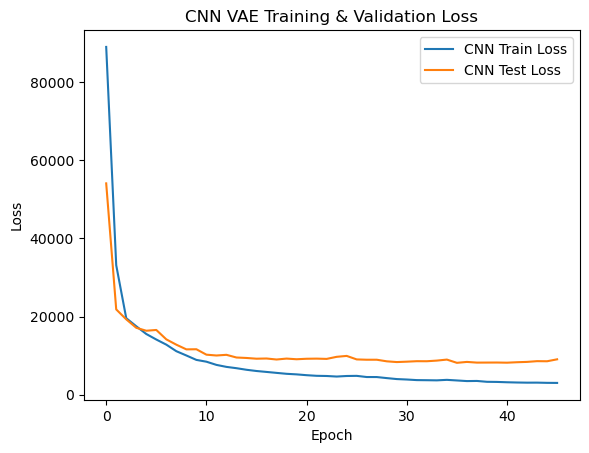

In [39]:
##############################################
# Phase 1: Train CNNMaskedVAE for missing data imputation
##############################################

input_dim = len(column_names)
hidden_dim = 256

# Initialize the imputation model (CNNMaskedVAE is wrapped inside NaNMaskedVAE)
cnn_vae = NaNMaskedVAE(input_dim, hidden_dim, latent_dim, seq_length).to(device)
optimizer_cnn = torch.optim.Adam(cnn_vae.parameters(), lr=1e-3)

# Train the CNN VAE (imputation model)
best_test_loss = float('inf')
patience = 10
patience_counter = 0
train_losses_cnn = []
test_losses_cnn = []

for epoch in range(1, epochs + 1):
    train_loss = train(cnn_vae, train_loader, optimizer_cnn, device)
    test_loss = test(cnn_vae, test_loader, device)
    train_losses_cnn.append(train_loss)
    test_losses_cnn.append(test_loss)
    print(f"[CNN VAE] Epoch {epoch}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")
    if test_loss < best_test_loss:
        best_test_loss = test_loss
        patience_counter = 0
        # Uncomment to save the best model weights:
        # torch.save(cnn_vae.state_dict(), "best_cnn_vae.pth")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered for CNN VAE!")
            break

# Optional: plot the training and validation loss curves
plt.plot(train_losses_cnn, label="CNN Train Loss")
plt.plot(test_losses_cnn, label="CNN Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("CNN VAE Training & Validation Loss")
plt.show()

## Models Training for Phase 1 and 2

In [40]:
##############################################
# Use the trained CNNMaskedVAE to impute missing values in the original data
##############################################
def impute_dataset(model, dataset, device):
    """
    Given a dataset of (input_dim, seq_length) samples with potential NaNs, 
    use the trained model to fill in missing values. Returns a list of 
    imputed samples, each retaining its original label.

    For each sample:
      1. Run the model’s forward pass to obtain reconstructed output.
      2. For each element, if the original value is NaN, replace it with 
         the reconstructed value; otherwise, keep the original value.
    """
    model.eval()
    imputed_samples = []
    for i in range(len(dataset)):
        x, label = dataset[i]  # x shape: (input_dim, seq_length)
        x_tensor = x.to(device)
        # Add batch dimension: (1, input_dim, seq_length)
        x_tensor = x_tensor.unsqueeze(0)
        with torch.no_grad():
            recon, _, _ = model(x_tensor)  # recon shape: (1, input_dim, seq_length)
        # Replace NaNs with reconstructed values; keep original otherwise
        x_imputed = torch.where(torch.isnan(x_tensor), recon, x_tensor)
        # Remove batch dimension and move to CPU
        imputed_samples.append((x_imputed.squeeze(0).cpu(), label))
    return imputed_samples


# Apply imputation to the original train and test splits
imputed_train_dataset = impute_dataset(cnn_vae, train_dataset, device)
imputed_test_dataset = impute_dataset(cnn_vae, test_dataset, device)

# Create new DataLoaders for the imputed datasets (using the same batch_size)
imputed_train_loader = DataLoader(imputed_train_dataset, batch_size=batch_size, shuffle=True)
imputed_test_loader  = DataLoader(imputed_test_dataset, batch_size=batch_size, shuffle=False)

Epoch 1, Train Loss: 74007.7587, Test Loss: 71180.7781
Epoch 2, Train Loss: 65297.9237, Test Loss: 60029.4974
Epoch 3, Train Loss: 53125.9119, Test Loss: 44943.7398
Epoch 4, Train Loss: 36797.4373, Test Loss: 27595.8074
Epoch 5, Train Loss: 22188.3060, Test Loss: 18463.9579
Epoch 6, Train Loss: 15192.3792, Test Loss: 24153.4356
Epoch 7, Train Loss: 16607.2036, Test Loss: 13848.9066
Epoch 8, Train Loss: 10100.1793, Test Loss: 6189.5209
Epoch 9, Train Loss: 4038.7374, Test Loss: 1669.7727
Epoch 10, Train Loss: 3532.1031, Test Loss: 6495.9723
Epoch 11, Train Loss: 3736.9761, Test Loss: 5144.9853
Epoch 12, Train Loss: 2687.6492, Test Loss: 4796.6055
Epoch 13, Train Loss: 2504.0768, Test Loss: 3836.5692
Epoch 14, Train Loss: 2507.8724, Test Loss: 3163.9533
Epoch 15, Train Loss: 2076.6700, Test Loss: 1381.3665
Epoch 16, Train Loss: 1135.1634, Test Loss: 573.1766
Epoch 17, Train Loss: 668.9710, Test Loss: 431.7908
Epoch 18, Train Loss: 455.5574, Test Loss: 379.2102
Epoch 19, Train Loss: 397.4

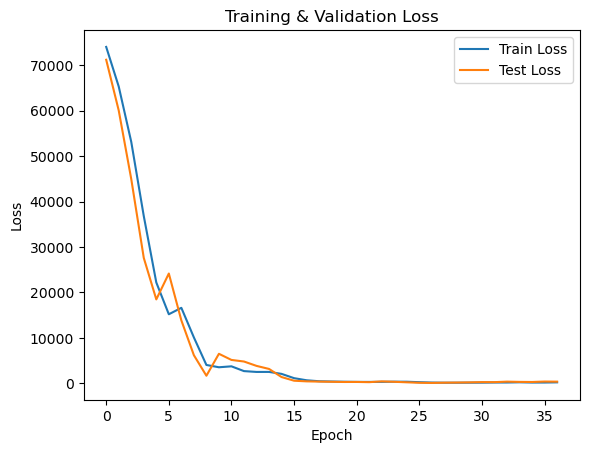

In [41]:
##############################################
# Phase 2: Train HMM-VAE model using imputed data
##############################################

HMM_model = HMM_NaNMaskedVAE(input_dim, hidden_dim, latent_dim, seq_length).to(device)
optimizer = torch.optim.Adam(HMM_model.parameters(), lr=1e-3)
    
# Initialize training variables
best_test_loss = float('inf')
patience_counter = 0
    
train_losses = []
test_losses = []

for epoch in range(1, epochs + 1):
    train_loss = HMM_train(HMM_model, imputed_train_loader, optimizer, device)
    test_loss = HMM_test(HMM_model, imputed_test_loader, device)
    train_losses.append(train_loss)
    test_losses.append(test_loss)

    print(f"Epoch {epoch}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")

    # Early stopping logic
    if test_loss < best_test_loss:
        best_test_loss = test_loss
        patience_counter = 0
        # Optional: save the best model here
        # torch.save(HMM_model.state_dict(), "best_model.pth")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered!")
            break

# Plot the training and validation loss curves
plt.plot(train_losses, label="Train Loss")
plt.plot(test_losses, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training & Validation Loss")
plt.show()


In [42]:
torch.save(cnn_vae.state_dict(), "cnn_vae_final.pth")
torch.save(HMM_model.state_dict(), "HMM_model_final.pth")

In [43]:
model=HMM_model
combined_dataset = ConcatDataset([train_dataset, test_dataset])
imputed_combined_dataset = impute_dataset(cnn_vae, combined_dataset, device)
combined_loader = DataLoader(imputed_combined_dataset, batch_size=batch_size, shuffle=True)

🔍 Detected 4 EEG channels.


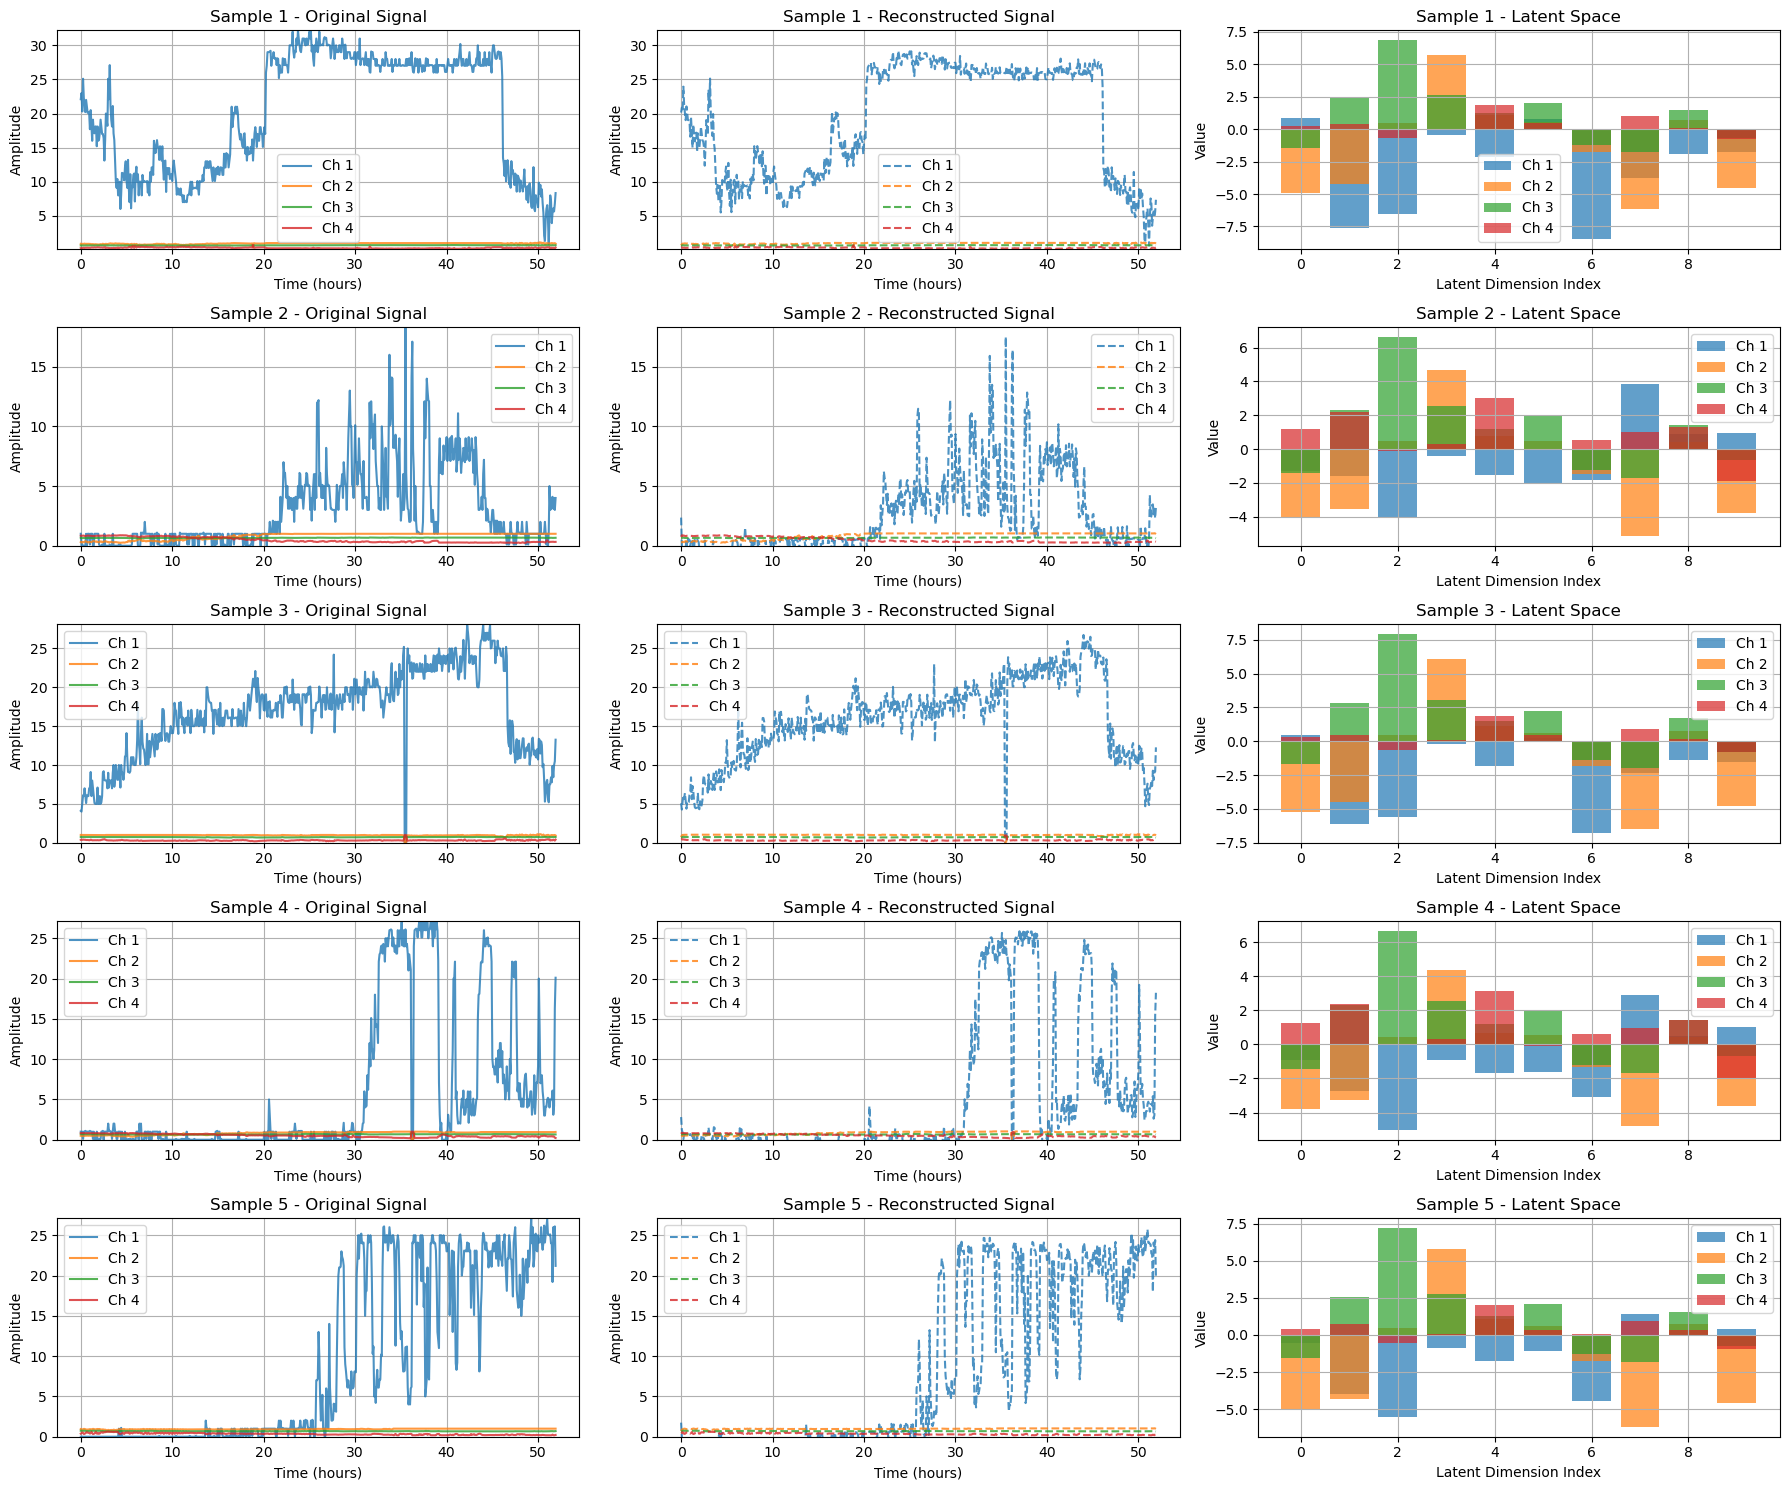

In [44]:
def check_reconstruction(model, dataloader, device, num_samples=3):
    """
    Visualize VAE-generated EEG reconstructions and the corresponding latent representations.
    
    Parameters:
    - model: trained VAE model
    - dataloader: DataLoader for the dataset
    - device: computation device (CPU or GPU)
    - num_samples: number of random samples to visualize
    """
    model.eval()  # Switch model to evaluation mode

    # Determine number of EEG channels
    num_channels = dataloader.dataset[0][0].shape[0]  # (num_channels, seq_length)
    print(f"🔍 Detected {num_channels} EEG channels.")

    # Create a figure with rows=num_samples and 3 columns
    fig, axes = plt.subplots(num_samples, 3, figsize=(18, 3 * num_samples))
    axes = np.atleast_2d(axes)  # Ensure axes is 2D array even if num_samples=1

    # Iterate over one batch from the DataLoader
    for batch_idx, (x, _) in enumerate(dataloader):  # Ignore labels
        x = x.to(device)  # Move data to the selected device

        # Perform reconstruction on the entire batch
        with torch.no_grad():
            recon_x, mu, _ = model(x)  # recon_x shape: (batch, num_channels, seq_length)

        # Randomly select samples from the batch to visualize
        indices = torch.randperm(x.size(0))[:num_samples]
        for i, idx in enumerate(indices):
            # Create time axis in hours (each index represents 5 minutes)
            time_axis = np.linspace(0, (x.shape[2] - 1) * 5 / 60, x.shape[2])

            # Determine global min/max across all channels for consistent y-axis limits
            all_min, all_max = float('inf'), float('-inf')
            for ch in range(num_channels):
                original_data = x[idx, ch].cpu().numpy()
                original_data = np.nan_to_num(original_data, nan=0.0)
                all_min = min(all_min, np.min(original_data))
                all_max = max(all_max, np.max(original_data))

            # (1) Plot original signals for each channel
            for ch in range(num_channels):
                original_data = x[idx, ch].cpu().numpy()
                original_data = np.nan_to_num(original_data, nan=0.0)  # Replace NaNs with 0
                axes[i, 0].plot(time_axis, original_data, label=f"Ch {ch+1}", alpha=0.8)
            
            axes[i, 0].set_title(f"Sample {i+1} - Original Signal")
            axes[i, 0].set_xlabel("Time (hours)")
            axes[i, 0].set_ylabel("Amplitude")
            axes[i, 0].legend()
            axes[i, 0].grid(True)
            axes[i, 0].set_ylim(all_min, all_max)

            # (2) Plot reconstructed signals for each channel
            for ch in range(num_channels):
                axes[i, 1].plot(
                    time_axis,
                    recon_x[idx, ch].cpu().numpy().squeeze(),
                    label=f"Ch {ch+1}",
                    linestyle="dashed",
                    alpha=0.8
                )
            
            axes[i, 1].set_title(f"Sample {i+1} - Reconstructed Signal")
            axes[i, 1].set_xlabel("Time (hours)")
            axes[i, 1].set_ylabel("Amplitude")
            axes[i, 1].legend()
            axes[i, 1].grid(True)
            axes[i, 1].set_ylim(all_min, all_max)

            # (3) Plot latent space values (mu) for each channel
            for ch in range(num_channels):
                axes[i, 2].bar(
                    range(len(mu[idx, ch].cpu().numpy())),
                    mu[idx, ch].cpu().numpy(),
                    alpha=0.7,
                    label=f"Ch {ch+1}"
                )
            axes[i, 2].set_title(f"Sample {i+1} - Latent Space")
            axes[i, 2].set_xlabel("Latent Dimension Index")
            axes[i, 2].set_ylabel("Value")
            axes[i, 2].legend()
            axes[i, 2].grid(True)

        break  # Only process a single batch

    # Adjust layout, save the figure, and display it
    plt.tight_layout()
    plt.show()

# Check reconstruction results
check_reconstruction(model, imputed_test_loader, device, num_samples=5)


In [45]:
def extract_latent_features(vae_model, dataset):
    """
    Extract latent features from a multi-channel VAE and normalize them.

    Parameters:
    - vae_model: a trained multi-channel VAE instance
    - dataset:    an EEG dataset where each item is (signal, label)

    Returns:
    - normalized_latent_features: 2D numpy array of shape (num_samples, num_channels * latent_dim)
      containing z-score–normalized latent features
    - labels:                     1D numpy array of sample labels
    """
    latent_features = []
    labels = []
    num_eeg_channels = vae_model.input_dim  # Ensure consistency with the model’s channel count

    # Switch VAE to evaluation mode
    vae_model.eval()

    with torch.no_grad():
        for i in range(len(dataset)):
            signal, label = dataset[i]

            # Ensure the signal is a tensor on the correct device
            if isinstance(signal, torch.Tensor):
                signal = signal.to(device)  # Shape: (num_channels, seq_length)
            else:
                signal = torch.tensor(signal, dtype=torch.float32).to(device)

            # Obtain per-channel latent vectors (shape: [1, num_channels, latent_dim])
            latent_vector = vae_model.get_embedding(signal.unsqueeze(0))

            # Move to CPU, flatten, and collect
            latent_features.append(latent_vector.cpu().numpy().flatten())
            labels.append(label)

    latent_features = np.array(latent_features)  # Shape: (num_samples, num_channels * latent_dim)

    # Perform z-score normalization across all samples for each latent dimension
    mean = np.mean(latent_features, axis=0, keepdims=True)
    std = np.std(latent_features, axis=0, keepdims=True)
    std[std == 0] = 1e-8  # Prevent division by zero
    normalized_latent_features = (latent_features - mean) / std

    print(f"✅ Feature extraction complete! Extracted {len(normalized_latent_features)} samples.")
    return normalized_latent_features, np.array(labels)


vae_models = model
latent_features, labels = extract_latent_features(model, imputed_combined_dataset)

✅ Feature extraction complete! Extracted 244 samples.


In [46]:
def visualize_pca(latent_features, labels, dimensions=2):
    """
    Perform PCA on latent features and visualize the results.

    Parameters:
    - latent_features: 2D numpy array of shape (n_samples, feature_dim)
    - labels: 1D numpy array of shape (n_samples,), sample labels (e.g., 0 or 1)
    - dimensions: int, target number of PCA components (2 or 3)
    """
    pca = PCA(n_components=dimensions)
    reduced_features = pca.fit_transform(latent_features)

    # Map labels to colors
    color_map = {0: 'blue', 1: 'red'}
    colors = [color_map[label] for label in labels]

    if dimensions == 2:
        plt.figure(figsize=(8, 6))
        plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=colors, alpha=0.7)

        # Create legend handles
        handles = [
            Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, alpha=0.7, label='Bad Outcome'),
            Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, alpha=0.7, label='Good Outcome')
        ]
        plt.legend(handles=handles, title="Labels")

        plt.title("PCA Projection of Latent Space (2D)")
        plt.xlabel("PCA Component 1")
        plt.ylabel("PCA Component 2")
        plt.grid(True)
        plt.show()

    elif dimensions == 3:
        fig = plt.figure(figsize=(10, 8))
        ax = fig.add_subplot(111, projection='3d')

        # 3D scatter plot
        ax.scatter(
            reduced_features[:, 0],
            reduced_features[:, 1],
            reduced_features[:, 2],
            c=colors,
            alpha=0.7
        )

        # Create legend handles for 3D plot
        handles = [
            Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, alpha=0.7, label='Bad Outcome'),
            Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, alpha=0.7, label='Good Outcome')
        ]
        ax.legend(handles=handles, title="Labels")
        ax.set_title("PCA Projection of Latent Space (3D)")
        ax.set_xlabel("PCA Component 1")
        ax.set_ylabel("PCA Component 2")
        ax.set_zlabel("PCA Component 3")
        plt.show()


def visualize_tsne(latent_features, labels, dimensions=2):
    """
    Perform t-SNE on latent features and visualize the results in 2D.

    Parameters:
    - latent_features: 2D numpy array of shape (n_samples, feature_dim)
    - labels: 1D numpy array of shape (n_samples,), sample labels (e.g., 0 or 1)
    - dimensions: int, target number of t-SNE components (only 2 is supported here)
    """
    tsne = TSNE(n_components=dimensions, perplexity=30, random_state=42)
    reduced_features = tsne.fit_transform(latent_features)

    # Map labels to colors
    color_map = {0: 'blue', 1: 'red'}
    colors = [color_map[label] for label in labels]

    plt.figure(figsize=(8, 6))
    plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=colors, alpha=0.7)

    # Create legend handles
    handles = [
        Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, alpha=0.7, label='Bad Outcome'),
        Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, alpha=0.7, label='Good Outcome')
    ]
    plt.legend(handles=handles, title="Labels")

    plt.title("t-SNE Projection of Latent Space (2D)")
    plt.xlabel("t-SNE Component 1")
    plt.ylabel("t-SNE Component 2")
    plt.grid(True)
    plt.show()



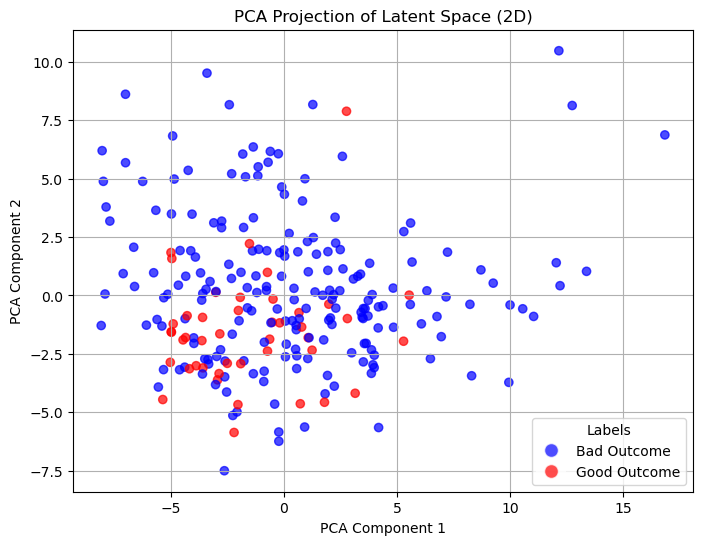

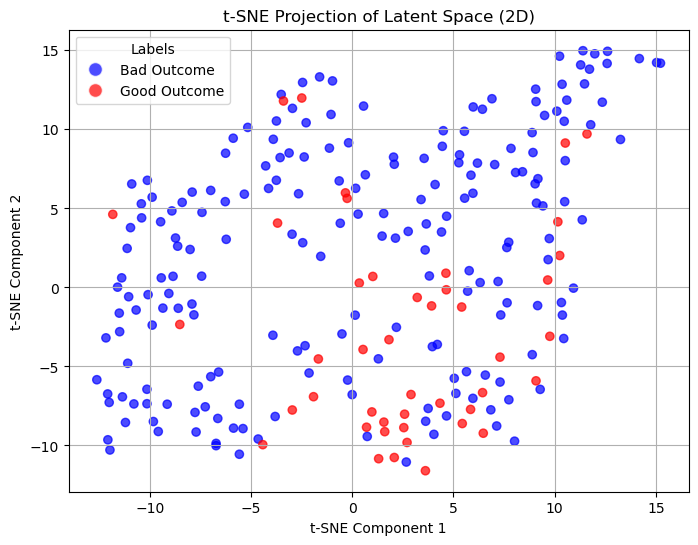

In [47]:
visualize_pca(latent_features, labels, dimensions=2)  
visualize_tsne(latent_features, labels, dimensions=2)  

In [48]:
# 🚀 Extract latent features for the training set
X_train, y_train = extract_latent_features(model, imputed_train_dataset)

# 🚀 Extract latent features for the testing set
X_test, y_test = extract_latent_features(model, imputed_test_dataset)

# 🚀 Ensure labels are NumPy arrays
labels_train = np.array(y_train)
labels_test = np.array(y_test)

# 🚀 Print class distribution to check balance
print(f"Training set class distribution: {np.bincount(labels_train)}")
print(f"Testing set class distribution: {np.bincount(labels_test)}")

# Apply SMOTE to balance the training set
smote = SMOTE(random_state=42)
smote = SMOTE(k_neighbors=2, random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)
# Optionally, balance the test set as well
# X_test, y_test = smote.fit_resample(X_test, y_test)

print(f"Resampled training set class distribution: {np.bincount(y_train)}")
print(f"Resampled testing set class distribution: {np.bincount(y_test)}")

✅ Feature extraction complete! Extracted 195 samples.
✅ Feature extraction complete! Extracted 49 samples.
Training set class distribution: [158  37]
Testing set class distribution: [42  7]
Resampled training set class distribution: [158 158]
Resampled testing set class distribution: [42  7]


✅ XGB Accuracy: 0.8163, AUC: 0.8401
✅ XGB Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.83      0.89        42
           1       0.42      0.71      0.53         7

    accuracy                           0.82        49
   macro avg       0.68      0.77      0.71        49
weighted avg       0.87      0.82      0.83        49

✅ XGB Confusion Matrix:
[[35  7]
 [ 2  5]]


C:\Users\admin\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [18:31:02] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


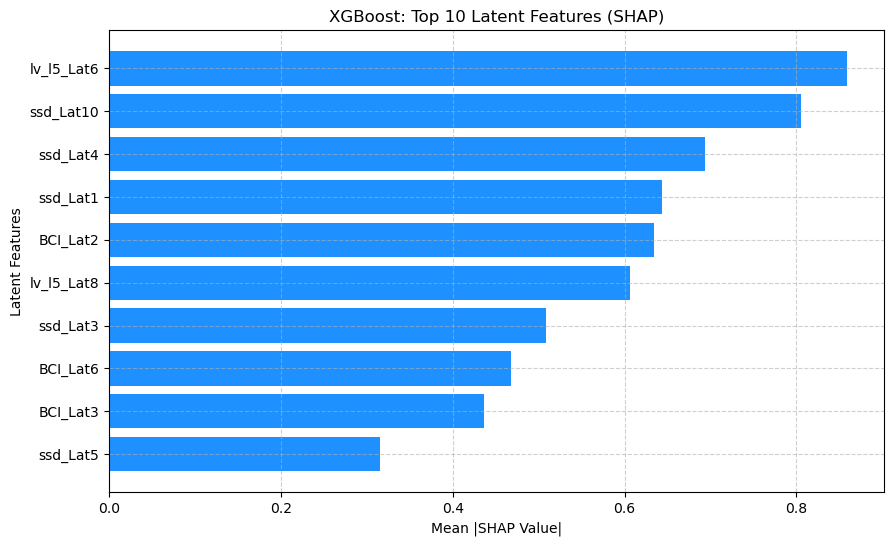

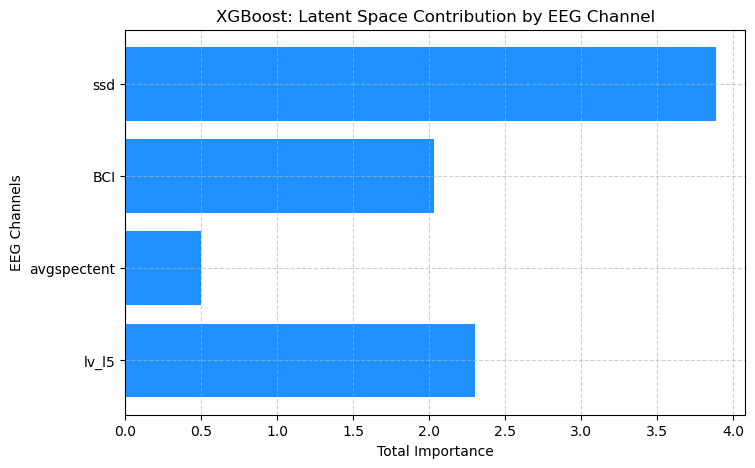

✅ EBM Accuracy: 0.8367, AUC: 0.8435
✅ EBM Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.88      0.90        42
           1       0.44      0.57      0.50         7

    accuracy                           0.84        49
   macro avg       0.68      0.73      0.70        49
weighted avg       0.86      0.84      0.84        49

✅ EBM Confusion Matrix:
[[37  5]
 [ 3  4]]


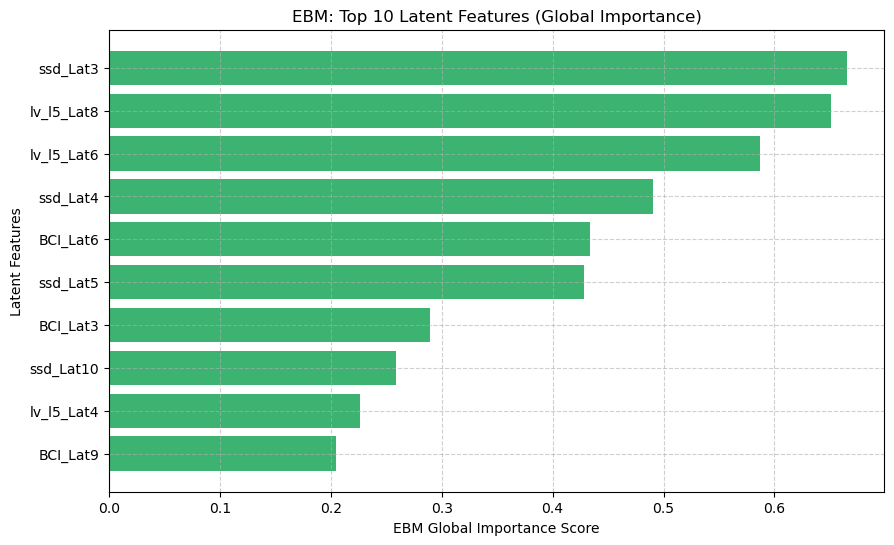

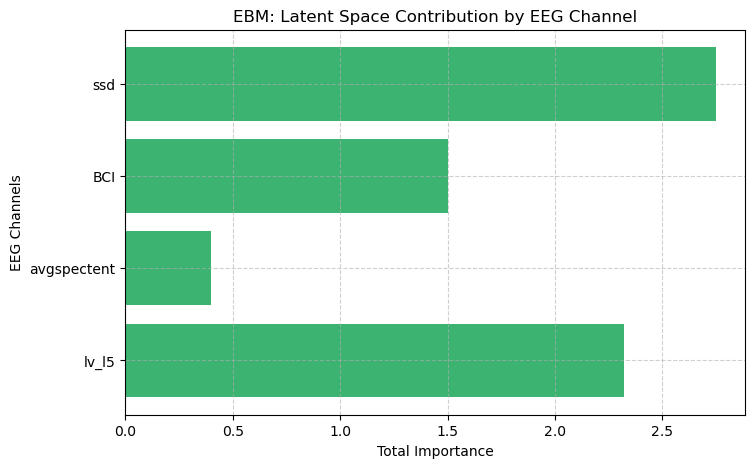

✅ CatBoost Accuracy: 0.7959, AUC: 0.8605
✅ CatBoost Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.83      0.88        42
           1       0.36      0.57      0.44         7

    accuracy                           0.80        49
   macro avg       0.64      0.70      0.66        49
weighted avg       0.84      0.80      0.81        49

✅ CatBoost Confusion Matrix:
[[35  7]
 [ 3  4]]


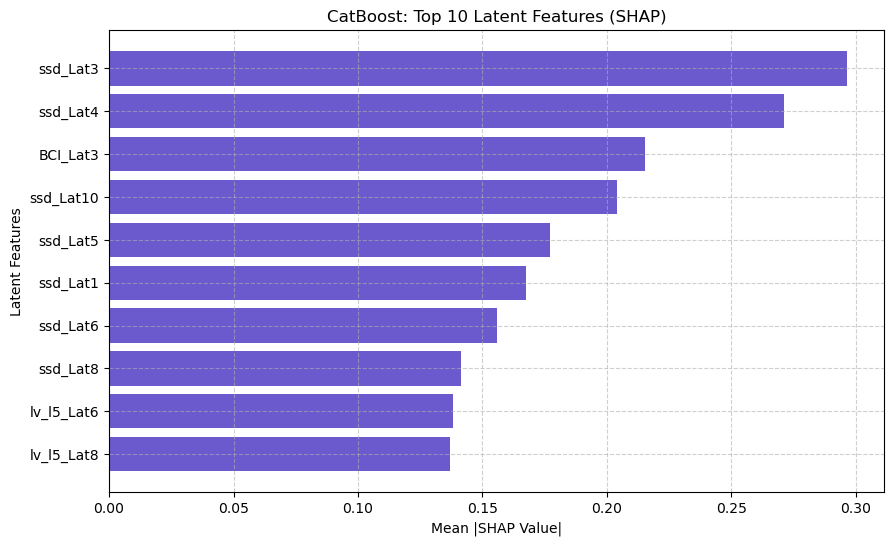

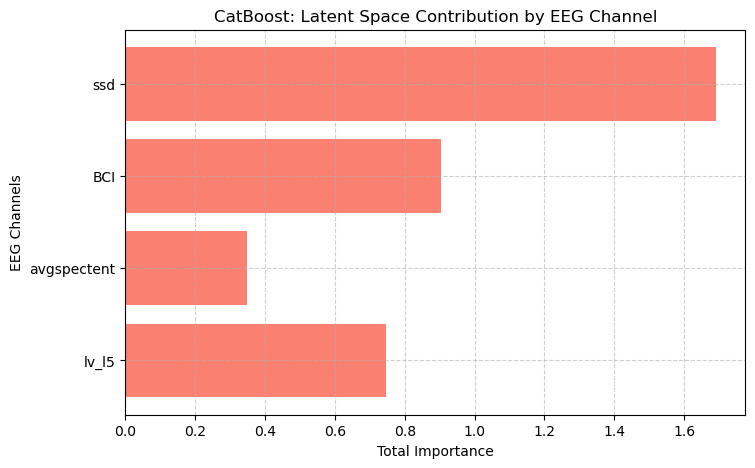

In [49]:
# -----------------------------------------------
# Train and evaluate XGBoost, EBM, and CatBoost,
# then visualize feature importances uniformly
# -----------------------------------------------
import re 
# 1. Generate feature names for latent dimensions
num_features = X_train.shape[1]
feature_names = [
    f"{column_names[ch]}_Lat{i+1}"
    for ch in range(num_eeg_channels)
    for i in range(latent_dim)
][:num_features]

# 2. Define a helper to plot top-K latent features
def plot_top_features(importances, names, title, color, xlabel):
    sorted_idx = np.argsort(importances)[::-1]
    top_k = 10
    plt.figure(figsize=(10, 6))
    plt.barh(
        [names[i] for i in sorted_idx[:top_k]],
        importances[sorted_idx[:top_k]],
        color=color
    )
    plt.xlabel(xlabel)
    plt.ylabel("Latent Features")
    plt.title(title)
    plt.gca().invert_yaxis()
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.show()

# 3. Define a helper to plot channel-level importances
def plot_channel_importance(importances, names, title, channel_list, color_map):
    # Sum importances per channel
    channel_importance = [
        np.sum(importances[i * latent_dim : (i + 1) * latent_dim])
        for i in range(len(channel_list))
    ]
    plt.figure(figsize=(8, 5))
    plt.barh(
        [channel_list[i] for i in range(len(channel_list))],
        channel_importance,
        color=[color_map[i] for i in range(len(channel_list))]
    )
    plt.xlabel("Total Importance")
    plt.ylabel("EEG Channels")
    plt.title(title)
    plt.gca().invert_yaxis()
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.show()

# 4. XGBoost Classification + SHAP
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
xgb_model.fit(X_train, y_train)

y_pred_xgb = xgb_model.predict(X_test)
y_pred_proba_xgb = xgb_model.predict_proba(X_test)
auc_xgb = roc_auc_score(y_test, y_pred_proba_xgb[:, 1])
acc_xgb = accuracy_score(y_test, y_pred_xgb)

print(f"✅ XGB Accuracy: {acc_xgb:.4f}, AUC: {auc_xgb:.4f}")
print("✅ XGB Classification Report:")
print(classification_report(y_test, y_pred_xgb))
print("✅ XGB Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_xgb))

# SHAP explanation for XGBoost
explainer_xgb = shap.TreeExplainer(xgb_model)
shap_vals_xgb = explainer_xgb.shap_values(X_test)
feat_imp_xgb = np.abs(shap_vals_xgb).mean(axis=0)

plot_top_features(
    feat_imp_xgb,
    feature_names,
    title="XGBoost: Top 10 Latent Features (SHAP)",
    color='dodgerblue',
    xlabel="Mean |SHAP Value|"
)
plot_channel_importance(
    feat_imp_xgb,
    feature_names,
    title="XGBoost: Latent Space Contribution by EEG Channel",
    channel_list=column_names,
    color_map=['dodgerblue'] * num_eeg_channels
)

# 5. EBM Classification + Global Explanation
ebm = ExplainableBoostingClassifier(random_state=42)
ebm.fit(X_train, y_train)

y_pred_ebm = ebm.predict(X_test)
y_pred_proba_ebm = ebm.predict_proba(X_test)
auc_ebm = roc_auc_score(y_test, y_pred_proba_ebm[:, 1])
acc_ebm = accuracy_score(y_test, y_pred_ebm)

print(f"✅ EBM Accuracy: {acc_ebm:.4f}, AUC: {auc_ebm:.4f}")
print("✅ EBM Classification Report:")
print(classification_report(y_test, y_pred_ebm))
print("✅ EBM Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_ebm))

# Extract EBM global feature importances
ebm_global = ebm.explain_global().data()
ebm_names = ebm_global["names"]
ebm_scores = ebm_global["scores"]

# Map EBM feature indices to our latent feature names
mapped_imp_ebm = []
mapped_names_ebm = []
for name, score in zip(ebm_names, ebm_scores):
    idx_match = re.fullmatch(r"feature_(\d+)", name)
    if idx_match:
        idx = int(idx_match.group(1))
        if idx < len(feature_names):
            mapped_names_ebm.append(feature_names[idx])
            mapped_imp_ebm.append(score)

# Convert to NumPy arrays
mapped_imp_ebm = np.array(mapped_imp_ebm)
mapped_names_ebm = np.array(mapped_names_ebm)

# Associate correct importances back to full feature index order
feat_imp_ebm = np.zeros(len(feature_names))
for fn, score in zip(mapped_names_ebm, mapped_imp_ebm):
    feat_imp_ebm[feature_names.index(fn)] = score

plot_top_features(
    feat_imp_ebm,
    feature_names,
    title="EBM: Top 10 Latent Features (Global Importance)",
    color='mediumseagreen',
    xlabel="EBM Global Importance Score"
)
plot_channel_importance(
    feat_imp_ebm,
    feature_names,
    title="EBM: Latent Space Contribution by EEG Channel",
    channel_list=column_names,
    color_map=['mediumseagreen'] * num_eeg_channels
)

# 6. CatBoost Classification + SHAP
cat_model = CatBoostClassifier(verbose=0, random_seed=42)
cat_model.fit(X_train, y_train)

y_pred_cat = cat_model.predict(X_test)
y_pred_proba_cat = cat_model.predict_proba(X_test)
auc_cat = roc_auc_score(y_test, y_pred_proba_cat[:, 1])
acc_cat = accuracy_score(y_test, y_pred_cat)

print(f"✅ CatBoost Accuracy: {acc_cat:.4f}, AUC: {auc_cat:.4f}")
print("✅ CatBoost Classification Report:")
print(classification_report(y_test, y_pred_cat))
print("✅ CatBoost Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_cat))

# SHAP explanation for CatBoost
explainer_cat = shap.TreeExplainer(cat_model)
shap_vals_cat = explainer_cat.shap_values(X_test)
feat_imp_cat = np.abs(shap_vals_cat).mean(axis=0)

plot_top_features(
    feat_imp_cat,
    feature_names,
    title="CatBoost: Top 10 Latent Features (SHAP)",
    color='slateblue',
    xlabel="Mean |SHAP Value|"
)
plot_channel_importance(
    feat_imp_cat,
    feature_names,
    title="CatBoost: Latent Space Contribution by EEG Channel",
    channel_list=column_names,
    color_map=['salmon'] * num_eeg_channels
)


In [50]:
def run_clustering_analysis(latent_features, labels, method='kmeans', min_clusters=2, max_clusters=10):
    silhouette_scores = []
    cluster_models = []

    for k in range(min_clusters, max_clusters):
        if method == 'kmeans':
            model = KMeans(n_clusters=k, random_state=42, n_init=10)
        elif method == 'gmm':
            model = GaussianMixture(n_components=k, random_state=42)
        elif method == 'agglo':
            model = AgglomerativeClustering(n_clusters=k)
        elif method == 'spectral':
            model = SpectralClustering(n_clusters=k, assign_labels='kmeans', random_state=42)
        else:
            raise ValueError("Unsupported clustering method.")
        
        cluster_labels = model.fit_predict(latent_features)
        score = silhouette_score(latent_features, cluster_labels)
        silhouette_scores.append(score)
        cluster_models.append((model, cluster_labels))

    optimal_idx = int(np.argmax(silhouette_scores))
    optimal_clusters = min_clusters + optimal_idx
    best_model, best_labels = cluster_models[optimal_idx]

    contingency_table = np.zeros((optimal_clusters, 2))
    group_good_bad_ratios = []

    for i in range(optimal_clusters):
        n_bad = np.sum((best_labels == i) & (labels == 0))
        n_good = np.sum((best_labels == i) & (labels == 1))
        contingency_table[i, 0] = n_bad
        contingency_table[i, 1] = n_good
        ratio = n_good / (n_bad + 1e-6)
        group_good_bad_ratios.append(ratio)
        print(f"✅ Cluster {i+1}: Good Count = {n_good}, Bad Count = {n_bad}, Good/Bad Ratio = {ratio:.4f}")

 
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    global_good = np.sum(labels == 1)
    global_bad = np.sum(labels == 0)
    global_ratio = global_good / (global_bad + 1e-6)
    t_stat, t_p_value = ttest_ind(group_good_bad_ratios, np.full_like(group_good_bad_ratios, global_ratio))

    # Silhouette plot
    plt.figure(figsize=(8, 6))
    plt.plot(range(min_clusters, max_clusters), silhouette_scores, marker='o', linestyle='--', color='b')
    plt.axvline(optimal_clusters, linestyle="--", color="r", label=f"Optimal K = {optimal_clusters}")
    plt.xlabel("Number of Clusters")
    plt.ylabel("Silhouette Score")
    plt.title(f"Silhouette Score vs Number of Clusters ({method})")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(contingency_table, annot=True, cmap="coolwarm", fmt=".0f",
                xticklabels=["Bad", "Good"],
                yticklabels=[f"Cluster {i+1}" for i in range(optimal_clusters)])
    plt.xlabel("Outcome")
    plt.ylabel("Cluster")
    plt.title("Outcome Distribution per Cluster")
    plt.show()

    # PCA
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(latent_features)

    plt.figure(figsize=(8, 6))
    for i in range(optimal_clusters):
        mask = best_labels == i
        plt.scatter(pca_result[mask, 0], pca_result[mask, 1], label=f"Cluster {i+1}", alpha=0.7)
    plt.legend()
    plt.xlabel("PCA 1")
    plt.ylabel("PCA 2")
    plt.title("PCA Projection of Clusters")
    plt.grid(True)
    plt.show()

    return best_labels, optimal_clusters, contingency_table, group_good_bad_ratios, global_ratio, chi2, p, dof, expected, t_stat, t_p_value


C:\Users\admin\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\admin\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\admin\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\admin\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Window

✅ Cluster 1: Good Count = 35, Bad Count = 120, Good/Bad Ratio = 0.2917
✅ Cluster 2: Good Count = 9, Bad Count = 80, Good/Bad Ratio = 0.1125


C:\Users\admin\anaconda3\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


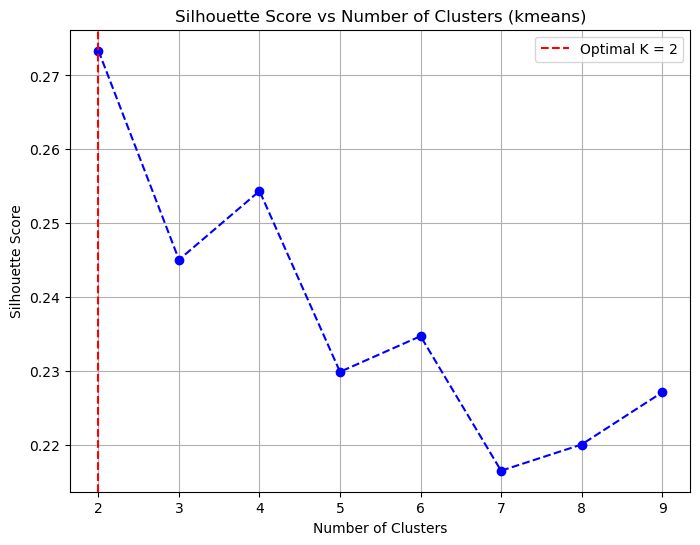

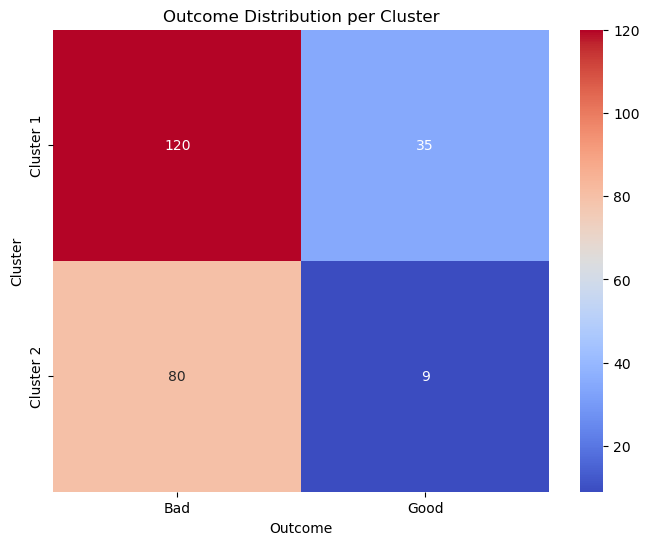

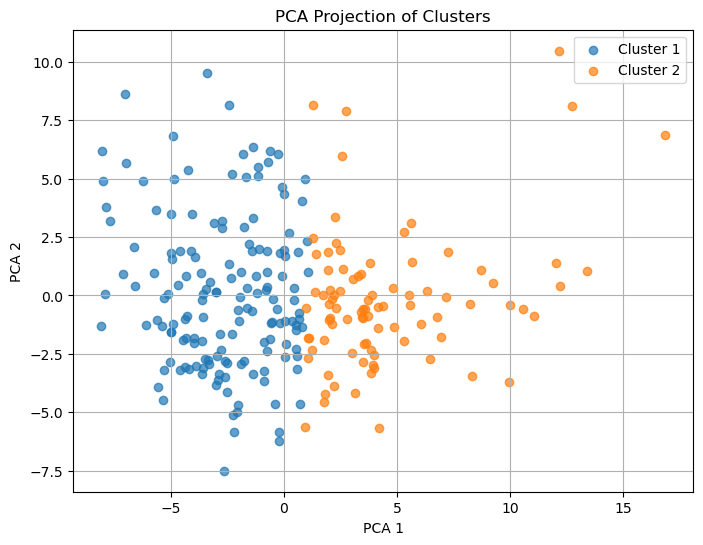

In [51]:
cluster_labels, optimal_clusters, contingency_table, group_ratios, global_ratio, chi2, p, dof, expected, t_stat, t_p = run_clustering_analysis(
    latent_features, labels, method='kmeans'  # support 'kmeans', 'gmm', 'agglo', 'spectral'
)

C:\Users\admin\AppData\Local\Temp\ipykernel_14308\1474876913.py:78: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


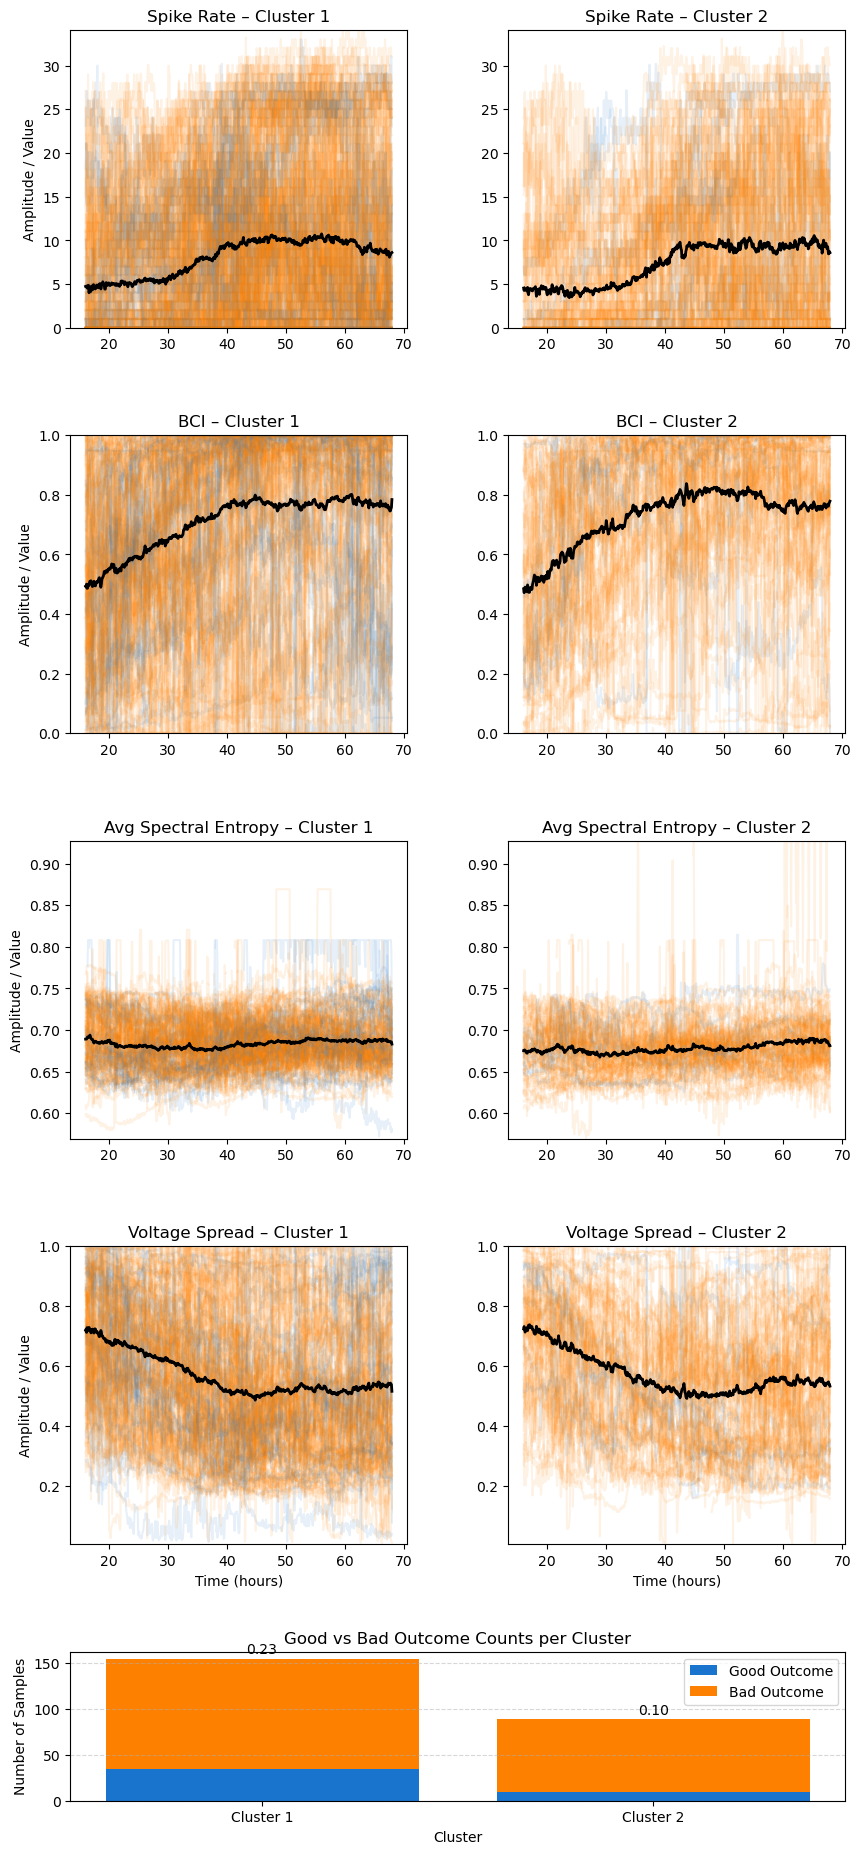

In [52]:
# 🚀 Retrieve original EEG data
raw_data = np.array([eeg_dataset_1[i][0].numpy() for i in range(len(eeg_dataset_1))])  # (n_samples, num_channels, time_steps)
num_channels= len(column_names) 
# Time-axis processing
time_per_step = 5 / 60  # Each time step represents 5 minutes (in hours)
time_axis = np.arange(raw_data.shape[2]) * time_per_step + start_time

# Compute global y-axis range (ignoring NaNs)
min_values = np.nanmin(raw_data, axis=(0, 2))
max_values = np.nanmax(raw_data, axis=(0, 2))

# Layout parameters
rows = num_channels + 1               # One row per EEG channel, plus one row for the bar chart
cols = optimal_clusters
height_ratios = [1] * num_channels + [0.5]  # Bottom bar chart row is half the height of an EEG row

fig_width = 5 * cols
fig_height = 5 * num_channels + 3     # Extra ~3 inches reserved for the bottom bar chart
fig = plt.figure(figsize=(fig_width, fig_height))

gs = GridSpec(
    rows,
    cols,
    figure=fig,
    height_ratios=height_ratios,
    hspace=0.4,
    wspace=0.3
)

column_names = ['Spike Rate', 'BCI', 'Avg Spectral Entropy', 'Voltage Spread']
# Colors for Good/Bad outcomes
color_good = '#1974CD'
color_bad = '#FE8000'

# — EEG subplots —
for ch in range(num_channels):
    for i in range(cols):
        ax = fig.add_subplot(gs[ch, i])
        mask = (cluster_labels == i)
        # Plot individual sample curves as background
        for sample, lab in zip(raw_data[mask, ch, :], labels[mask]):
            c = color_good if lab == 1 else color_bad
            ax.plot(time_axis, sample, color=c, alpha=0.1)
        # Plot mean curve
        mean_curve = np.nanmean(raw_data[mask, ch, :], axis=0)
        ax.plot(time_axis, mean_curve, color='black', linewidth=2)
        # Title & labels
        ax.set_title(f"{column_names[ch]} – Cluster {i+1}")
        if i == 0:
            ax.set_ylabel("Amplitude / Value")
        if ch == num_channels - 1:
            ax.set_xlabel("Time (hours)")
        ax.set_ylim(min_values[ch], max_values[ch])
        ax.grid(False)

# — Bottom stacked bar chart (spans all columns) —
bar_ax = fig.add_subplot(gs[num_channels, :])
good_counts = [int(np.sum((cluster_labels == i) & (labels == 1))) for i in range(cols)]
bad_counts = [int(np.sum((cluster_labels == i) & (labels == 0))) for i in range(cols)]
cluster_names = [f"Cluster {i+1}" for i in range(cols)]

bars_good = bar_ax.bar(cluster_names, good_counts, color=color_good, label='Good Outcome')
bars_bad = bar_ax.bar(cluster_names, bad_counts, bottom=good_counts, color=color_bad, label='Bad Outcome')

bar_ax.set_xlabel('Cluster')
bar_ax.set_ylabel('Number of Samples')
bar_ax.set_title('Good vs Bad Outcome Counts per Cluster')
bar_ax.legend()
bar_ax.grid(axis='y', linestyle='--', alpha=0.5)

# Annotate ratio above each bar
for i, (g, b) in enumerate(zip(good_counts, bad_counts)):
    total = g + b
    ratio = g / total if total > 0 else 0
    y = total * 1.02  # Position label 2% above the total height
    bar_ax.text(i, y, f"{ratio:.2f}", ha='center', va='bottom')

plt.tight_layout()
plt.show()


C:\Users\admin\AppData\Local\Temp\ipykernel_14308\1014726214.py:76: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(


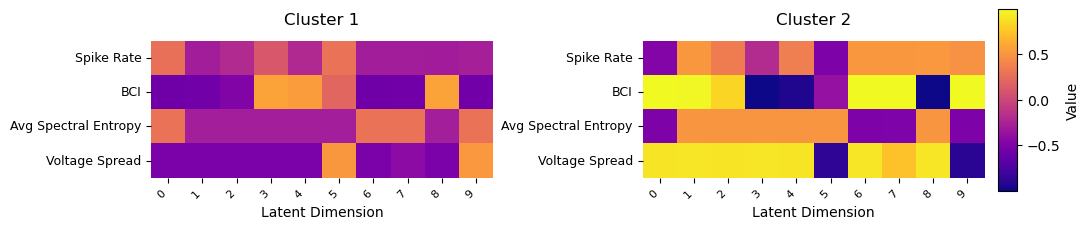

In [53]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

# --- 1. Compute the average latent feature for each cluster ---
unique_clusters = np.unique(cluster_labels)
num_clusters = len(unique_clusters)

cluster_avgs = []
for cluster in unique_clusters:
    idxs = np.where(cluster_labels == cluster)[0]
    avg = latent_features[idxs].mean(axis=0)
    cluster_avgs.append(avg)
cluster_avgs = np.stack(cluster_avgs, axis=0)

global_min = cluster_avgs.min()
global_max = cluster_avgs.max()

# --- 2. Layout: 1 row with (num_clusters + 1) columns; last column reserved for colorbar ---
fig_height = max(4, 0.5 * num_channels + 1)
fig, axes = plt.subplots(
    1,
    num_clusters + 1,
    figsize=(5 * num_clusters, fig_height),
    gridspec_kw={'width_ratios': [1] * num_clusters + [0.05]},
    constrained_layout=True
)
axes = axes.ravel()

# --- 3. Plot a heatmap for each cluster ---
for i, cluster in enumerate(unique_clusters):
    ax = axes[i]
    mat = cluster_avgs[i].reshape(num_channels, latent_dim)
    sns.heatmap(
        mat,
        ax=ax,
        cmap='plasma',
        vmin=global_min,
        vmax=global_max,
        square=True,
        cbar=False,
        xticklabels=True,
        yticklabels=column_names
    )
    ax.set_title(f"Cluster {cluster+1}", pad=12)
    ax.set_xlabel("Latent Dimension")
    # ax.set_ylabel("Channel")  # Can be enabled if vertical label is desired
    ax.tick_params(axis='x', labelsize=8)
    ax.tick_params(axis='y', labelsize=9)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=8)
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=9)

# --- 4. Manually shorten the colorbar axis height and position it ---
cax = axes[-1]
pos = cax.get_position()
scale = 0.5
new_height = pos.height * scale
# Adjust position: center vertically and shift slightly to the right
dx = 0.02
cax.set_position([
    pos.x0 + dx,
    pos.y0 + (pos.height - new_height) / 2,
    pos.width,
    new_height
])

# Draw the colorbar on the adjusted cax
norm = Normalize(vmin=global_min, vmax=global_max)
sm = ScalarMappable(norm=norm, cmap='plasma')
sm.set_array([])
fig.colorbar(sm, cax=cax, orientation='vertical').set_label('Value')

# --- 5. Fine-tune the overall layout and increase horizontal spacing between plots ---
plt.subplots_adjust(
    left=0.05,
    right=0.95,
    top=0.90,
    bottom=0.10,
    wspace=0.6  # Increase horizontal spacing between subplots
)

plt.show()
